In [1]:
from mizani.formatters import scientific_format
from mizani.breaks import date_breaks
from mizani.formatters import date_format
import numpy as np
import pandas as pd
from plotnine import *
import skmisc
import sys


from dataclasses import dataclass
from datetime import datetime
from datetime import timedelta
from typing import Dict, List, Optional, Tuple
from pandas.core.frame import DataFrame

# read in custom modules
sys.path.append('/Users/rosekantor/work/wbe_data_analysis/')
from read_gsheets import * 
from reprocess_qpcr import *
from calculations import *
from qa_qc import *
from quality_score import *

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [2]:
sites = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/site_lookup_040721.csv'
samples = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/sample_inventory_040721.csv'
qpcr = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/QuantStudio_raw_data_040721.csv'
plates = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/Plate_info_040721.csv'
sample_log = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/Sample_collection_log_031121.csv'
sample_metadata = '/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/Sample_metadata_031121.csv'

# 1. Load all data tables

In [3]:
sampling_df = read_sample_logs(None, None, None, sample_log, sample_metadata)
extraction_df = read_sample_data(None, None, samples, sites)
qpcr_plate_df = read_plate_data(None, None, plates)
qpcr_raw_df = read_qpcr_data(None, None, qpcr)

# 2. process qPCR data

In [4]:
## remove Xeno from targets (this was an inhibition control, we no longer use)
qpcr_raw_df = qpcr_raw_df[qpcr_raw_df.Target != 'Xeno']

## find plates that contained only standards and drop them
plates_samples = set(qpcr_raw_df[qpcr_raw_df.Task == 'Unknown'].plate_id)
plates_standards = set(qpcr_raw_df[qpcr_raw_df.Task == 'Standard'].plate_id)
plates_standards_only = plates_standards - plates_samples
qpcr_raw_df = qpcr_raw_df[~qpcr_raw_df.plate_id.isin(plates_standards_only)]

## replace all standard curves with default by dropping them at this step
## catch standards in a separate df
plate_standards_df = qpcr_raw_df[qpcr_raw_df.Task == 'Standard']
plate_samples_df = qpcr_raw_df[qpcr_raw_df.Task != 'Standard']

## process the qPCR data <- the bulk of the code happens in this step
qpcr_processed_dilutions, plate_target_info_samples = process_qpcr_plate(plate_samples_df)
qpcr_processed = choose_dilution(qpcr_processed_dilutions)

# make column listing number of technical replicates detected, based on the non-detect count (this could be build into process_qpcr_plate instead)
qpcr_processed['detected_of_3_TechReps'] = 3 - qpcr_processed['nondetect_count']

## process just the standards (if they have been removed from the data)
with warnings.catch_warnings(): # ignore warnings that there are no NTCs, this call runs only standards
    warnings.simplefilter("ignore")
    qpcr_processed_dilutions_stds, plate_target_info_stds = process_qpcr_plate(plate_standards_df)

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice


# 3. merge tables together from qpcr and extraction

In [5]:
## 3a. merge qpcr plate info for samples and standards
### (code was initially designed to keep standards and samples together, but we are splitting them now to force use of default standard curves; could do this more elegantly)
plate_target_info_stds = plate_target_info_stds[['num_points', 'slope', 'intercept', 'r2', 'efficiency', 'loq_Cq', 'loq_Quantity', 'plate_id', 'Target']]
plate_target_info_samples = plate_target_info_samples[['used_default_curve', 'plate_id', 'Target', 'Target_full', 'intraassay_var', 'ntc_is_neg', 'ntc_Cq']]

if not len(plate_target_info_samples) == len(plate_target_info_stds):
    warnings.warn("plate_target_info dataframes from stds and samples are different lengths")
if not set(plate_target_info_samples.plate_id) == set(plate_target_info_stds.plate_id):
    warnings.warn("not all samples plates had stds") # we already dropped plates that had stds but no samples

plate_target_info_stds_samples = plate_target_info_samples.merge(plate_target_info_stds, on=['plate_id', 'Target'], how='left')
plate_target_info_all = plate_target_info_stds_samples.merge(qpcr_plate_df, on='plate_id', how='left')
# note: qpcr_plate_df contains some plates that were tests, not all will be in plate_target_info_stds_samples

if not len(plate_target_info_all) == len(plate_target_info_stds_samples):
    warnings.warn("plate_id duplicate rows introduced") 

    
## 3b. merge sample data, qPCR data, and plate data
if set(qpcr_processed.Sample) - set(extraction_df.sample_id) != set():
    warnings.warn("samples found in qPCR data that are not in extraction data")

extraction_df_qpcr = qpcr_processed.merge(extraction_df, how = 'left', left_on = 'Sample', right_on = 'sample_id')
extraction_df_qpcr = extraction_df_qpcr.merge(plate_target_info_all, how = 'left', on = ['plate_id', 'Target'])

if not len(extraction_df_qpcr) == len(qpcr_processed):
    warnings.warn("plate target info merge resulted in new rows") # check no new rows were introduced

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: plate_target_info dataframes from stds and samples are different lengths
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: not all samples plates had stds


# 4. pull out extraction controls and report them for each batch, if they exist
(should do this here or fairly early so that extraction controls are removed from the dataset)

In [6]:
before_merge_len = len(extraction_df_qpcr)
extraction_df_qpcr = get_extraction_control(extraction_df_qpcr)
if not before_merge_len == len(extraction_df_qpcr):
    warnings.warn("merging extraction data resulted in extra rows")

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/pandas/core/series.py:4200: RuntimeWarning: Mean of empty slice
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: merging extraction data resulted in extra rows


# 5. get bCoV recovery
(could happen any time, needed for quality_score())

In [7]:
bcov_recovery = calculate_recovery(extraction_df_qpcr, 'bCoV')
before_merge_len = len(extraction_df_qpcr)
extraction_df_qpcr = extraction_df_qpcr.merge(bcov_recovery, how='left', on='Sample')
if not len(extraction_df_qpcr) == before_merge_len:
    warnings.warn("bCoV recovery merge resulted in new rows")

# 6. calculate gc/L
(can happen any time after extraction_df and qpcr_processed are merged, needed before pulling out PMMoV data below)

In [8]:
extraction_df_qpcr['gc_per_mL'] = calculate_gc_per_ml(extraction_df_qpcr)

# 7. merge master table with sample collection data
(could happen any time, entries in sampling_df needed for quality_score())

In [9]:
extraction_df_qpcr = extraction_df_qpcr.merge(sampling_df, how='left', on=['sample_code', 'date_sampling'])

# 8. pull PMMoV data out and merge back onto N1 data in preparation for quality_score()
effectively shifting from longer to wider format

In [10]:
n1_df = extraction_df_qpcr[extraction_df_qpcr.Target == 'N1']
pmmov_df = extraction_df_qpcr[extraction_df_qpcr.Target == 'PMMoV'][['Sample', 'gc_per_mL']]
pmmov_df = pmmov_df.rename(columns={'gc_per_mL': 'pmmov_gc_per_mL'})
before_merge_len = len(n1_df)
n1_df = n1_df.merge(pmmov_df, how='left', on='Sample')
if not len(n1_df) == before_merge_len:
    warnings.warn("PMMoV merge resulted in new rows")

# calculate N1 per PMMoV
n1_df['N1_per_PMMoV'] = n1_df.gc_per_mL / n1_df.pmmov_gc_per_mL

# 9. calculate quality scores and add to master table

In [11]:
quality_scores = quality_score(n1_df)
n1_df_scored = n1_df.merge(quality_scores, how='left', on=['Sample', 'plate_id', 'Target'])
if not len(n1_df_scored) == len(n1_df):
    warnings.warn("quality score merge introduced new rows")

n1_df_scored = n1_df_scored.rename(columns={'gc_per_mL': 'SARS_CoV_2_N1_gc_per_mL'})

/Users/rosekantor/work/wbe_data_analysis/quality_score.py:111: RuntimeWarning: Mean of empty slice
/Users/rosekantor/work/wbe_data_analysis/quality_score.py:219: RuntimeWarning: Mean of empty slice


In [12]:
# option to save final scored master table (e.g. for the dashboard)
# n1_df_scored.to_csv('/Users/rosekantor/scientific_work/Nelson_lab/wbe_project/data_wbe/processed_data_thru_031121.csv', index=False)

# 10. Prepare to make some example plots

In [13]:
# do some filtering and formatting
n1_df_scored = n1_df_scored[~n1_df_scored.sample_level.isin(['control', 'Effluent'])]
n1_df_scored = n1_df_scored[~n1_df_scored.sample_level.isna()]
n1_df_scored = n1_df_scored[~n1_df_scored.replicate.str.contains('sw')]
n1_df_scored.detected_of_3_TechReps = n1_df_scored.detected_of_3_TechReps.astype('category') 

# reformat wide-to-long for plotting
df_long = n1_df_scored[['site_full_name', 'utility_name', 'sample_code', 'sample_level', 'county',
                        'date_sampling', 'replicate', 'quality_score', 'detected_of_3_TechReps',
                        'SARS_CoV_2_N1_gc_per_mL', 'pmmov_gc_per_mL', 'N1_per_PMMoV']]

df_long = df_long.melt(id_vars=['site_full_name', 'utility_name', 'sample_code', 'sample_level', 'county',
                                'date_sampling', 'replicate', 'quality_score', 'detected_of_3_TechReps'],
                       value_vars=['SARS_CoV_2_N1_gc_per_mL', 'pmmov_gc_per_mL', 'N1_per_PMMoV'],
                       value_name='value',
                       var_name='measurement')

In [14]:
# aggregate data by biological replicates and calculate geometric means
df_agg = df_long.groupby(['sample_code', 'date_sampling', 'sample_level', 'county', 'site_full_name', 'utility_name', 'measurement']).agg(lambda x: x.tolist()).reset_index()
df_agg['gmean_value'] = df_agg.value.apply(lambda x: get_gmean(x))
df_agg['gstd_value'] = df_agg.value.apply(lambda x: get_gstd(x))
df_agg['gmean_value_upper'] = df_agg.gmean_value * df_agg.gstd_value
df_agg['gmean_value_lower'] = df_agg.gmean_value / df_agg.gstd_value

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 52 rows containing missing values.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_errorbar : Removed 502 rows containing missing values.


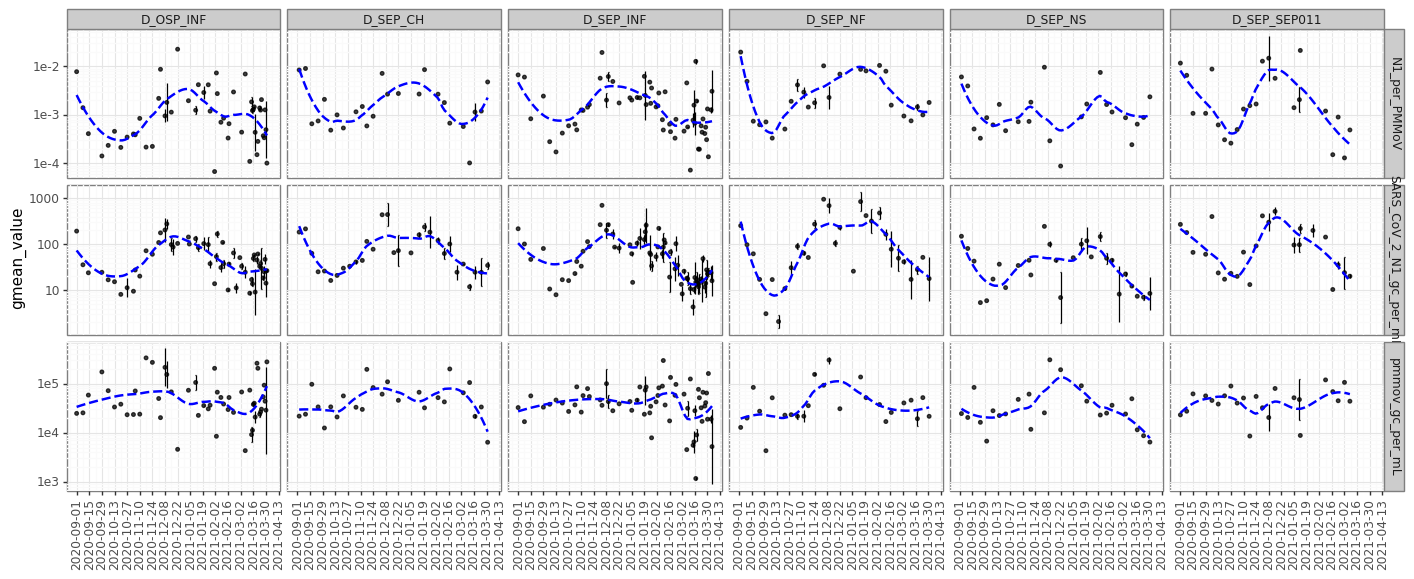

<ggplot: (302525821)>

In [15]:
# filter on one county and make example plot
df_agg_filtered =  df_agg[(df_agg.county == 'SF') & (df_agg.sample_level != 'Residential')].copy()
# fill NaNs with zero so these samples still show up in the plots
#df_agg_filtered.loc[df_agg_filtered.gmean_gc_per_mL.isna(), 'gmean_gc_per_mL'] = 0

plt = (ggplot(df_agg_filtered, aes(x='date_sampling', y='gmean_value')) +
geom_point(size=1, alpha=0.75)+
geom_errorbar(aes(ymin='gmean_value_lower', ymax='gmean_value_upper'))+
geom_smooth(method='loess', span=0.5, se=False, linetype='dashed', color='blue')+
geom_abline(slope=0, intercept=10, linetype='dashed')+
#ylab('value\n\n')+
xlab("")+
scale_y_log10()+
scale_x_datetime(breaks = '2 week')+
facet_grid('measurement ~ sample_code', scales='free_y')+ #, 
theme_bw()+ theme(axis_text_x=element_text(rotation=90, hjust=1.1), figure_size=(17,6)) )

display(plt)

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 45'. Pick better value with 'binwidth'.


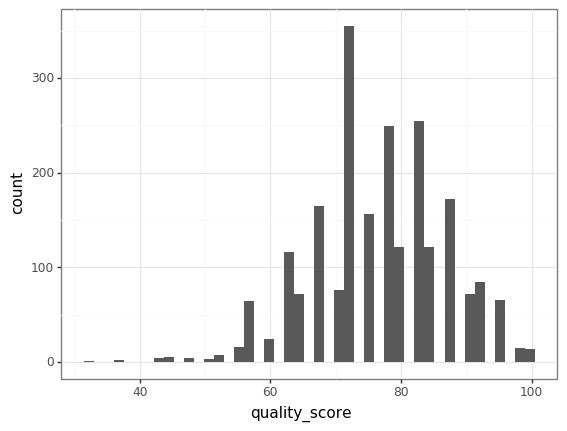

<ggplot: (303354177)>

In [16]:
(ggplot(n1_df_scored, aes(x='quality_score'))+
geom_histogram()+
theme_bw())

# Plots illustrating how some of the cut-offs quality score were chosen

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 75'. Pick better value with 'binwidth'.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 5 rows containing non-finite values.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 2 rows containing missing values.


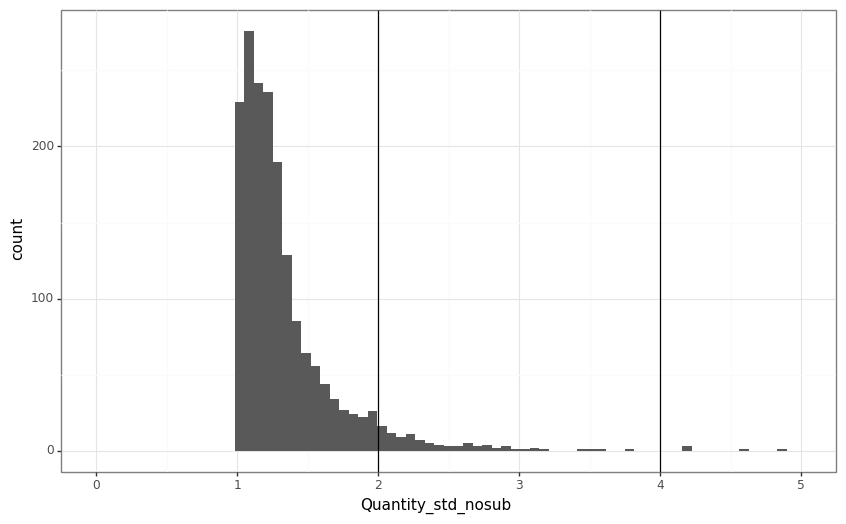

<ggplot: (307581709)>

In [17]:
(ggplot(extraction_df_qpcr[(extraction_df_qpcr.Target == 'N1') & ~(extraction_df_qpcr.Quantity_std_nosub.isna())], aes(x='Quantity_std_nosub'))+
geom_histogram()+
geom_vline(xintercept=2)+
geom_vline(xintercept=4)+
theme_bw()+
theme(figure_size=(10,6))+
xlim(0,5)
)

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 41'. Pick better value with 'binwidth'.
/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 28 rows containing non-finite values.


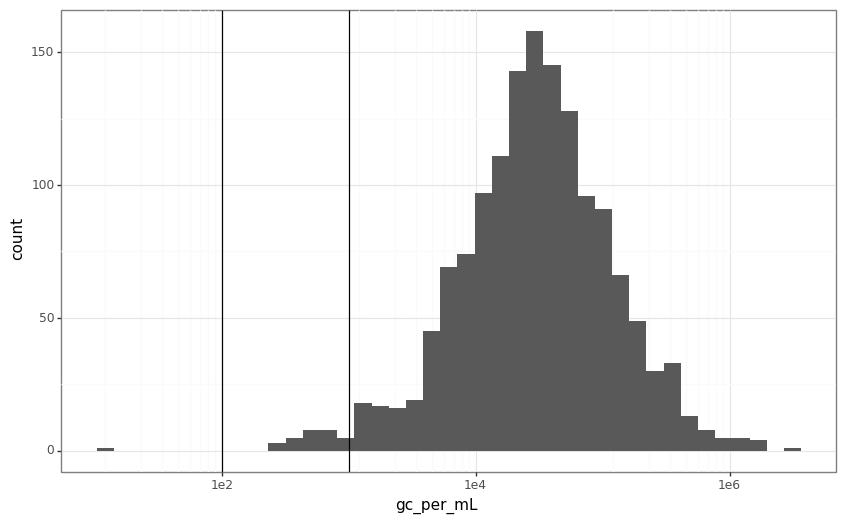

<ggplot: (304043181)>

In [18]:
pmmov = extraction_df_qpcr[extraction_df_qpcr.Target == 'PMMoV']
(ggplot(pmmov, aes(x='gc_per_mL'))+
geom_histogram()+
theme_bw()+
theme(figure_size=(10,6))+
scale_x_log10()+
geom_vline(xintercept=1e3)+
geom_vline(xintercept=1e2))

In [19]:
extraction_df_qpcr[(extraction_df_qpcr.Target == 'N1') & ~(np.isnat(extraction_df_qpcr.date_extract))].shape
extraction_df_qpcr[(extraction_df_qpcr.Target == 'N1') & (~extraction_df_qpcr.processing_error.isna())].shape

(40, 100)

# look at consistency of bovine coronavirus spike concentrations over time:

/Users/rosekantor/.pyenv/versions/3.7.5/lib/python3.7/site-packages/plotnine/layer.py:372: PlotnineWarning: stat_bin : Removed 3 rows containing non-finite values.


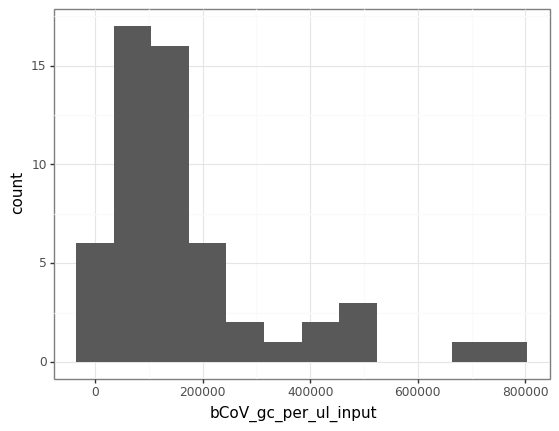

<ggplot: (308770609)>

In [20]:
spike_name = 'bCoV'
df = extraction_df_qpcr[extraction_df_qpcr.Target == spike_name].copy()
# calculate total recovered gene copies
df['total_recovered'] = df['elution_vol_ul'].astype(float) * df['Quantity_mean'].astype(float) / df['template_volume'].astype(float)

# calculate concentration gene copies / ul in just the spikes
spikes = df[df.Sample.str.contains(f'control_spike_{spike_name}')].copy()
spikes[f'{spike_name}_gc_per_ul_input'] = spikes['Quantity_mean'].astype(float) / spikes['template_volume'].astype(float)

spikes[spikes.dilution==100]#[[f'{spike_name}_gc_per_ul_input', f'{spike_name}_spike_tube', 'dilution']].sort_values('bCoV_spike_tube')
(ggplot(spikes[spikes.dilution==100], aes(x='bCoV_gc_per_ul_input'))+
geom_histogram(bins=12)+
theme_bw())

# left over from testing quality score

In [21]:
weights_dict = {
        'sample_collection':[5],
        'sample_hold_time':[5],
        'extraction_neg_control':[10],
        'extraction_processing_error':[10],
        'extraction_recovery_control':[10],
        'extraction_fecal_control':[10],
        'qpcr_neg_control':[10],
        'qpcr_efficiency':[10],
        'qpcr_num_points':[10],
        'qpcr_stdev_techreps':[10],
        'qpcr_inhibition':[10],
        }

scores_dict = {
        'sample_collection':[1],
        'sample_hold_time':[1],
        'extraction_neg_control':[1],
        'extraction_processing_error':[1],
        'extraction_recovery_control':[1],
        'extraction_fecal_control':[1],
        'qpcr_neg_control':[1],
        'qpcr_efficiency':[1],
        'qpcr_num_points':[1],
        'qpcr_stdev_techreps':[1],
        'qpcr_inhibition':[.5],
        }

In [22]:
test_df = {'Sample': ['sample_name1'],
        'Target': ['N1'],
        'plate_id': [1001],
        'Sample_type': [np.nan],
        'Number of hours represented by composite': [24],
        'Additional notes about the sample': [''],
        'date_extract': ['2021-01-02'],
        'date_sampling': ['2021-01-01'],
        'extraction_control_is_neg': [True],
        'extraction_control_Cq': [np.nan],
        'Cq': [[33.3,33.2,33.1]],
        'processing_error': [''],
        'bCoV_perc_recovered': [np.nan],
        'pmmov_gc_per_mL': [1e5],
        'ntc_is_neg': [True],
        'ntc_Cq': [np.nan],
        'efficiency': [.99],
        'num_points': [7],
        'Quantity_std_nosub': [1.5],
        'is_inhibited': [False]}
test_df = pd.DataFrame(test_df)
test_df = test_df.rename(columns={'Number of hours represented by composite': 'total_hrs_sampling',
                             'Additional notes about the sample': 'sampling_notes'})
test_df.date_extract = pd.to_datetime(test_df.date_extract)
test_df.date_sampling = pd.to_datetime(test_df.date_sampling)
test_df

,Sample,Target,plate_id,Sample_type,total_hrs_sampling,sampling_notes,date_extract,date_sampling,extraction_control_is_neg,extraction_control_Cq,Cq,processing_error,bCoV_perc_recovered,pmmov_gc_per_mL,ntc_is_neg,ntc_Cq,efficiency,num_points,Quantity_std_nosub,is_inhibited
0,sample_name1,N1,1001,NaN,24,,2021-01-02,2021-01-01,True,NaN,"[33.3, 33.2, 33.1]",,NaN,100000.0,True,NaN,0.99,7,1.5,False


In [23]:
quality_score(test_df)

,Sample,Target,plate_id,quality_score,flag,point_deduction,estimation
0,sample_name1,N1,1001,75.0,missing sample type; extraction processing error; missing Spike-in control virus recovery,extraction processing error: sample ; missing Spike-in control virus recovery,under
